In [1]:
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import numpy as np
import cv2 

In [2]:
def find_face(img,classifier,scale,min_detect,draw = False):
#fonction qui a partir d'une cascade de classifieur pré entrainer (Haar), detecte
#les visages dans img. 
#img : l'image dans laquelle on souhaite detecter le visage
#classifier : instanciation du classifieur considéré
#return faces : de dimension nb_visage_detecté * 4 , renvoi les coordonées x,y point en haut a gauche dela boite
#et w,h (largeur, hauteur) de la boite

    
    #convertit l'image en niveau de gris
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    

    #detection des visages
    faces = classifier.detectMultiScale(gray, scale, min_detect)
    
    #dessine des rectangle autour des visages trouvé
    if (draw):
        rgb = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
        for (x, y, w, h) in faces:
            fig, ax = plt.subplots()
            ax.imshow(rgb)
            rect = Rectangle((x,y),w,h,linewidth=1,edgecolor='r',facecolor='none')
            ax.add_patch(rect)
            ax.scatter(x,y)
            ax.scatter(x+w,y+h)
    
    return faces

def reject_non_max(faces):
    #fonction qui garde la boite qui correspond au visage "principal"
    #on suppose juste que le visage principal sera a priori plus grand que les autres
    if (len(faces) == 0) :
        return faces
    
    max_index = 0
    max_surface = faces[0][2]*faces[0][3] #w*h pour 1er visage
    
    for i in range(1,len(faces),1):
        
        if faces[i][2]*faces[i][3] > max_surface:
            max_index = i
            max_surface = faces[i][2]*faces[i][3]
    
    
    return faces[max_index]


def crop_img(img,crop_size,face):
    #fonction qui a partir permet de garder une ROI de taille crop_size à partir d'une détéction de visage
    #face : contient les informations du visage que l'on souhaite garder dans l'image
    #img : image RGB d'origine
    #crop_size : taille final de l'image
    #return : une image de taille crop_size centré autour du visage d'intêret
    
    img_size = img.shape
    
    #si aucun visage n'a été détécté dans l'image, 
    #ou si le visage est trop petit on considere que c'est une mauvaise détéction
    #on renvoit une image cropé centré
    if (len(face) == 0 or face[2]*face[3] < (img_size[0]*img_size[1]/9)) :
        xmin = int(img_size[0]/2) - int(crop_size[0]/2)
        xmax = int(img_size[0]/2) + int(crop_size[0]/2)
        ymin = int(img_size[1]/2) - int(crop_size[1]/2)
        ymax = int(img_size[1]/2) + int(crop_size[1]/2)
        return img[ymin:ymax,xmin:xmax,:]
        
    #si le visage est "d'assez bonne qualité"
    expand_x = crop_size[0] - face[2]
    expand_y = crop_size[1] - face[3]
    
    #calcul des indices de l'image a croper
    xmin = face[0] - int( expand_x/2 )
    xmax = face[0] + face[2] + int( expand_x/2 )
    if (face[2]%2 != 0) :
        xmax = xmax+1
    
    ymin = face[1] - int( expand_y/2 )
    ymax = face[1] + face[3] + int( expand_y/2 )
    if (face[3]%2 != 0) :
        ymax = ymax+1
      
    #gestion des bords, si les nouveaux indices sont en dehors de l'image
    if xmin < 0 :
        xmin = 0
        xmax = crop_size[0]
    
    if xmax > img_size[0]:
        xmax = img_size[0]-1
        xmin = xmax - crop_size[0] 
        
    if ymin < 0 :
        ymin = 0
        ymax = crop_size[1]
    
    if ymax > img_size[1]:
        ymax = img_size[1]-1
        ymin = ymax - crop_size[1]

    return img[ymin:ymax,xmin:xmax,:]

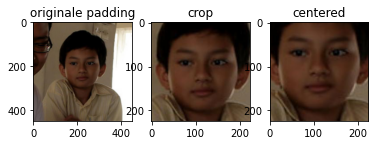

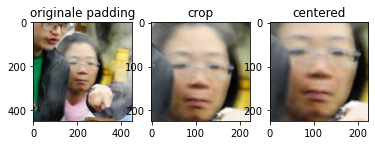

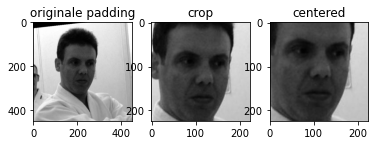

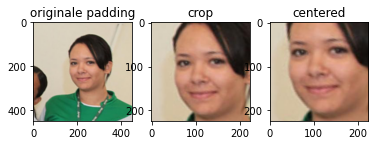

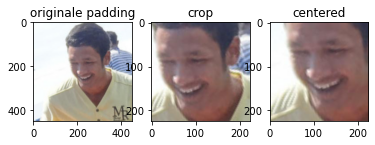

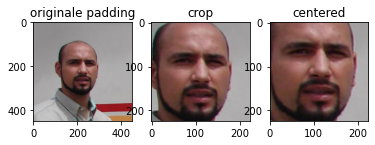

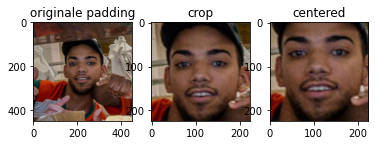

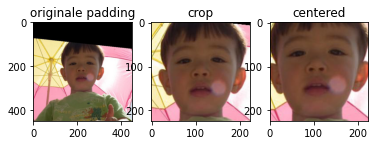

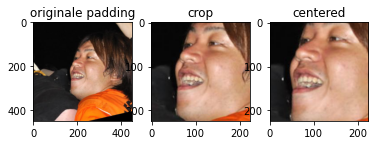

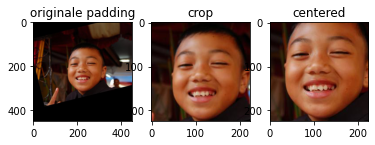

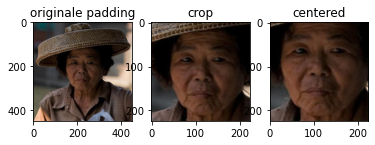

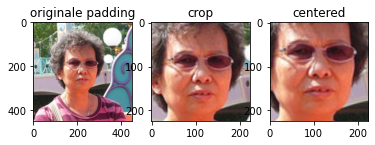

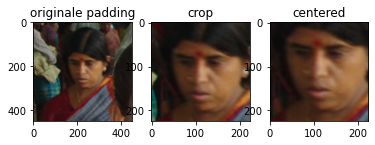

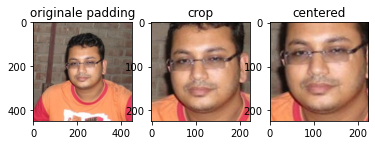

In [3]:
#chargement de la cascade de classifieur et definition des parametres
face_cascade = cv2.CascadeClassifier('haarcascade_frontalface_default.xml') #classifieur pour trouver visage
scale = 1.1
min_detect = 4

'''
#lecture d'une seule image d'entrée
img = cv2.imread('padding_125/train/10.jpg')
rgb = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)


faces = find_face(img,face_cascade,scale,min_detect,draw=True)
print("all faces ",faces)
faces = reject_non_max(faces)
print("best face ",faces)

crop = crop_img(rgb,(224,224),faces)
print("crop",crop.shape)
plt.figure()
plt.imshow(crop)
plt.title('crop')
'''
#affichage de quelques images
for i in range(1,15,1):
    
    #lecture de l'image
    path = 'padding_125/val/'+ str(i)+'.jpg'
    path2 = 'padding_025/val/'+ str(i)+'.jpg'
    
    img = cv2.imread(path)
    rgb = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    
    img2 = cv2.imread(path2)
    rgb2 = cv2.cvtColor(img2,cv2.COLOR_BGR2RGB)
    #trouver les visages a l'aide du classifieur
    faces = find_face(img,face_cascade,scale,min_detect)
    
    #choix du "meilleur visage"
    best_face = reject_non_max(faces)
    
    #crop
    crop = crop_img(rgb,(224,224),best_face)
    
    #affichage
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
    ax1.set_title('originale padding')
    ax2.set_title('crop')
    ax3.set_title('centered')
    ax1.imshow(rgb)
    ax2.imshow(crop)
    ax3.imshow(rgb2)